Predict the closing stock price of NASDAQ: NVDA for trading days from 24 October - 4 November (inclusive). There will be no restrictions on the data sources used (e.g. you may use relevant macro-economic indicators). Predictions will be compared with actual (after 4 November, but you have to submit before 23 October) using RMSE.


This implementation is the ARIMA model used to predict the closing stock prices

**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

**Importing Dataset**

In [ ]:
# Read CSV
df = pd.read_csv('./NVDA_2Year.csv', index_col = 'Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
19/10/2020,139.029999,139.835007,134.067505,134.977493,134.728363,29806800
20/10/2020,135.835007,137.997498,135.070007,136.455002,136.203186,22921200
21/10/2020,136.250000,137.914993,134.774994,135.247498,134.997894,21959600
22/10/2020,135.225006,136.117493,132.317505,133.610001,133.363403,29048000
23/10/2020,134.500000,135.932495,132.912506,135.902496,135.651672,23348400
...,...,...,...,...,...,...
10/10/2022,120.370003,121.239998,114.080002,116.699997,116.699997,69869900
11/10/2022,115.610001,118.459999,112.830002,115.860001,115.860001,66748200
12/10/2022,115.790001,117.349998,113.449997,115.000000,115.000000,49259000


**Data Visualization**

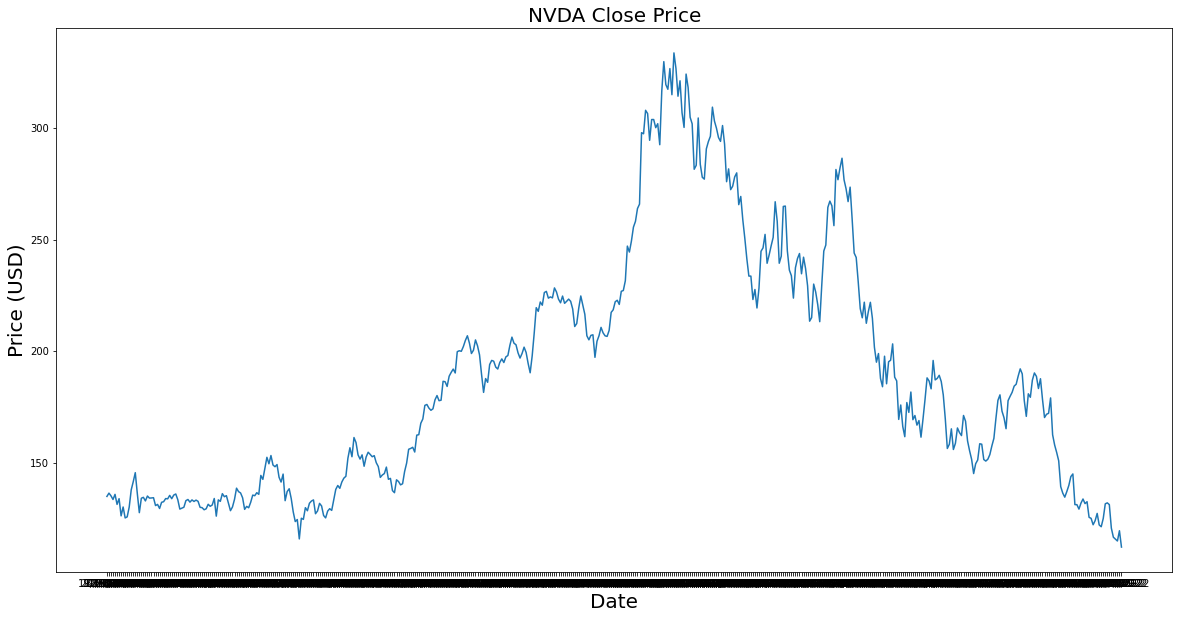

In [ ]:
plt.figure(figsize=(20,10)) 
plt.title('NVDA Close Price', fontsize=20)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Price (USD)', fontsize = 20)
plt.show()

Stationary data means they do not have trend or any seasonal efforts. Non-stationary data means that it has to convert it to stationary data before putting it into the ARIMA model. 
To check, we just need to use the Augmented Dicky Fuller test.

**ADF Test**

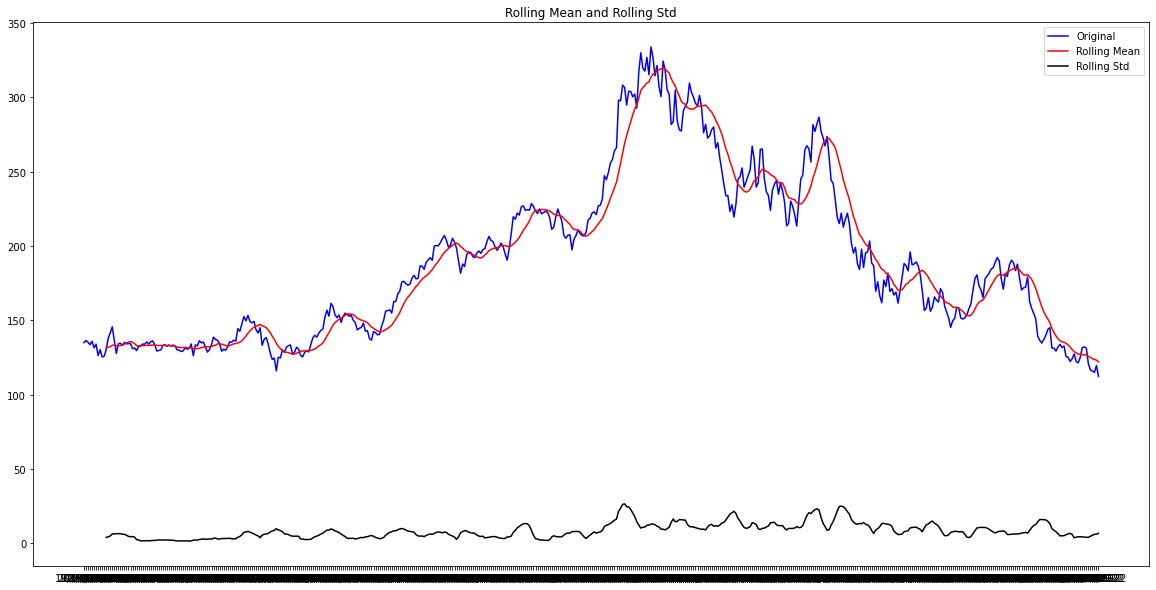

Results
Test Stats                      -1.225154
p-value                          0.662683
Number of lags used              0.000000
Number of observations used    501.000000
Critical value (1%)             -3.443470
Critical value (5%)             -2.867326
Critical value (10%)            -2.569852
dtype: float64


In [ ]:
data_close = df['Close']
def adf_test(timeseries):
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()
    plt.figure(figsize = (20, 10))
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(moving_average, color = 'red', label = 'Rolling Mean')
    plt.plot(moving_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Rolling Std')
    plt.show(block = False)
    print("Results")
    adft = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adft[0:4], index = ["Test Stats", "p-value", "Number of lags used", "Number of observations used"])
    for key, value in adft[4].items():
        output['Critical value (%s)'%key]=value
    print(output)

adf_test(df['Close'])

Since p-value > 0.05, the null hypothesis is not rejected and thus, the time series data is not stationary.

<Figure size 432x288 with 0 Axes>

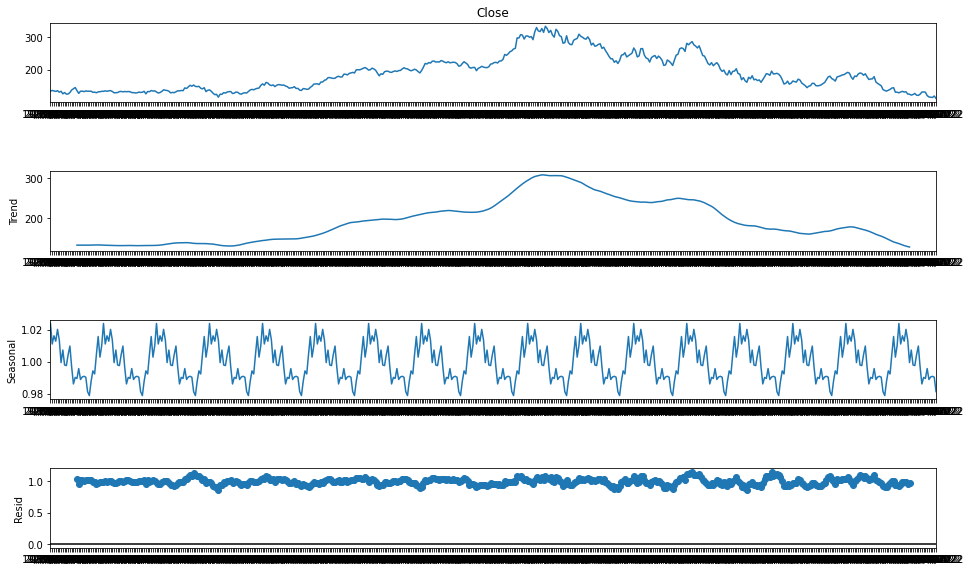

In [ ]:
# Separating Trend and Seasonality
result = seasonal_decompose(data_close, model = 'multiplicative', period =  30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

As mentioned earlier, we need to convert non-stationary data to stationary data.

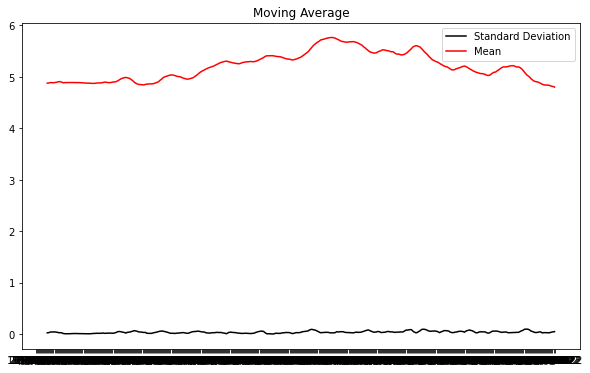

In [ ]:
# Conversion
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
log_data = np.log(data_close)
moving_avg = log_data.rolling(12).mean()
std_dev = log_data.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

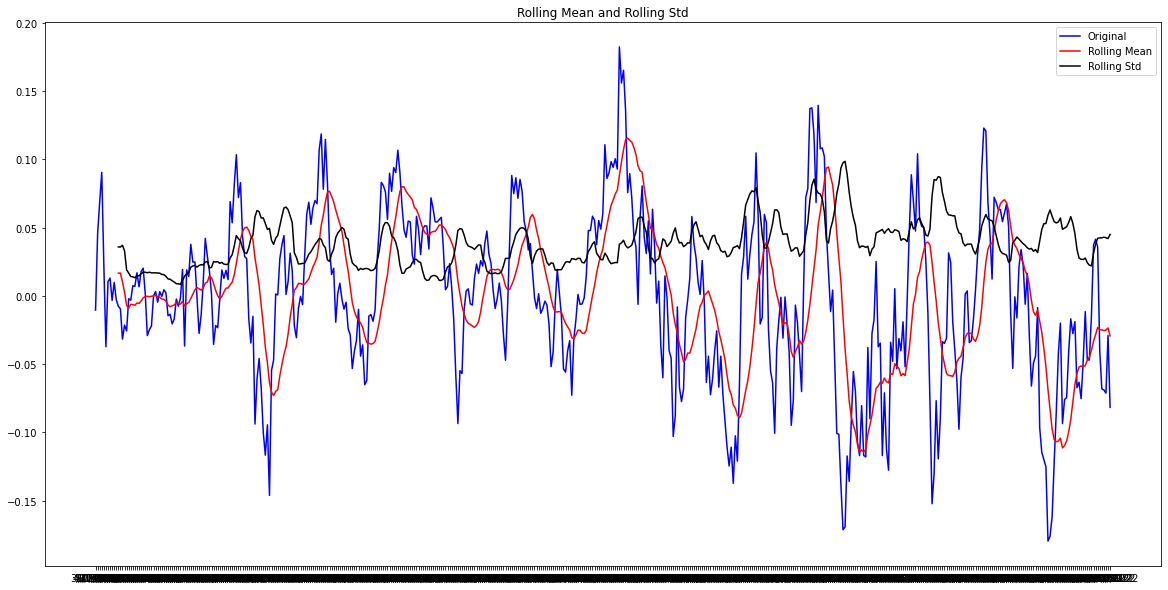

Results
Test Stats                    -5.758820e+00
p-value                        5.735645e-07
Number of lags used            0.000000e+00
Number of observations used    4.900000e+02
Critical value (1%)           -3.443766e+00
Critical value (5%)           -2.867457e+00
Critical value (10%)          -2.569921e+00
dtype: float64


In [ ]:
data_log_minus_mean = log_data - moving_avg
data_log_minus_mean.dropna(inplace = True)
adf_test(data_log_minus_mean)

Since p-value < 0.05, we can reject the null hypothesis and the time series data is stationary.

**Splitting the Data**

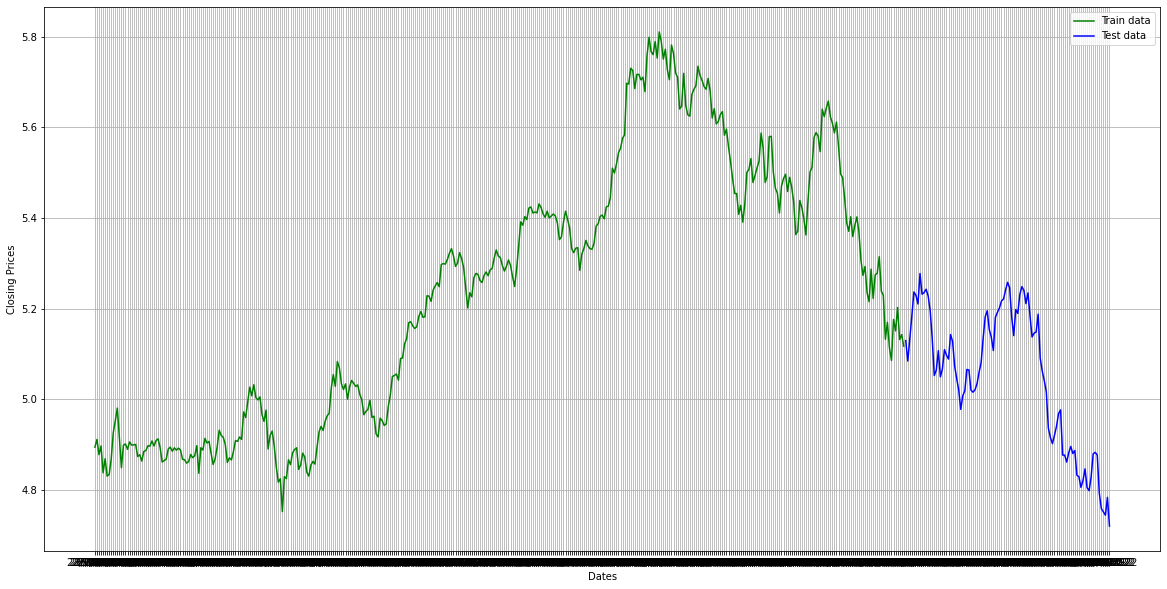

In [ ]:
train_data, test_data = log_data[3:int(len(log_data)*0.8)], log_data[int(len(log_data)*0.8):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

**Using Auto-ARIMA**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3355.545, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3350.513, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3351.922, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3351.873, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3348.535, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3353.635, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.600 seconds


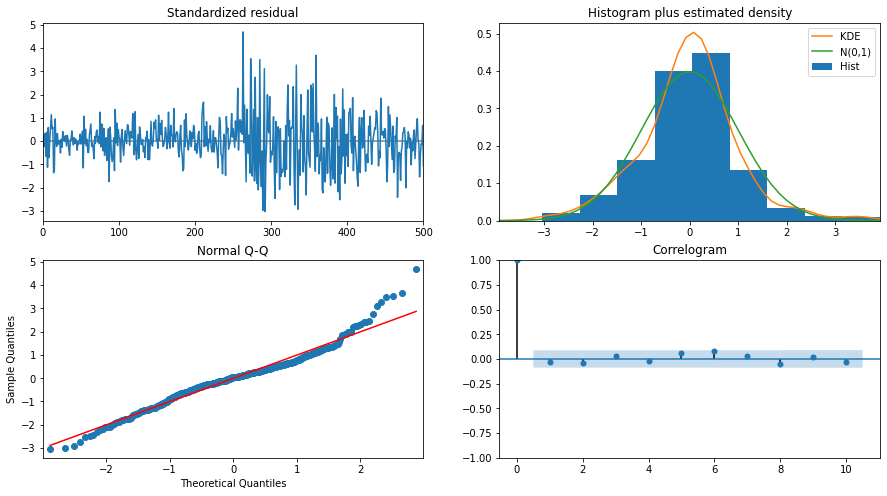

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  502
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1673.267
Date:                Sun, 23 Oct 2022   AIC                           3348.535
Time:                        03:42:34   BIC                           3352.752
Sample:                             0   HQIC                          3350.189
                                - 502                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        46.6108      2.061     22.619      0.000      42.572      50.650
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):               100.82
Prob(Q):                              0.44   Pr

In [ ]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(data_close, trace=True, suppress_warnings=True, stepwise=True)
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

print(model_autoARIMA.summary())

**Building the Model**

In [ ]:
model = ARIMA(train_data, order = (0, 1, 1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  398
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 801.165
Date:                Sun, 23 Oct 2022   AIC                          -1598.330
Time:                        03:57:11   BIC                          -1590.362
Sample:                             0   HQIC                         -1595.174
                                - 398                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0726      0.049     -1.476      0.140      -0.169       0.024
sigma2         0.0010    6.5e-05     15.909      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels

**Making Predictions with the model**

In [ ]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
pred = fitted.predict(start = start, end = end, type = 'levels')
pred.index = df.index[start:end + 1]
print(pred)

Date
18/5/2022     5.119448
19/5/2022     5.119448
20/5/2022     5.119448
23/5/2022     5.119448
24/5/2022     5.119448
                ...   
5/10/2022     5.119448
6/10/2022     5.119448
7/10/2022     5.119448
10/10/2022    5.119448
11/10/2022    5.119448
Name: predicted_mean, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


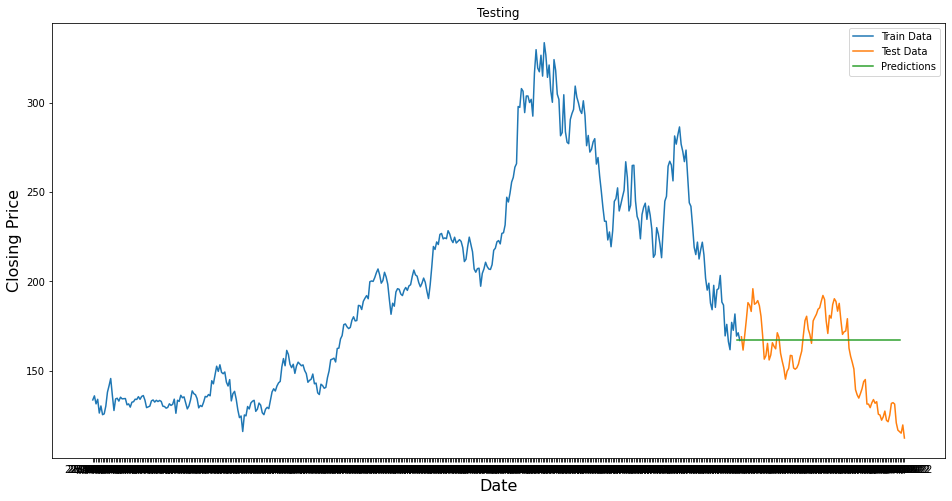

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Testing')
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Closing Price', fontsize=16)
plt.plot(np.exp(train_data), label = "Train Data")
plt.plot(np.exp(test_data), label = "Test Data")
plt.plot(np.exp(pred), label = "Predictions")
plt.legend()
plt.show()

In [ ]:
fitted_v2 = ARIMA(data_close, order = (4,1,4))
fitted_v2 = fitted_v2.fit()
dates_to_predict = pd.date_range(start = "2022-10-24", end = "2022-11-04")
pred = fitted_v2.predict(start=len(df), end=len(df)+11).rename("Closing Price Predictions")
pred.index = dates_to_predict
print(pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels

2022-10-24    112.457693
2022-10-25    112.786067
2022-10-26    113.254630
2022-10-27    113.683836
2022-10-28    113.130775
2022-10-29    112.838323
2022-10-30    112.259857
2022-10-31    112.642906
2022-11-01    113.023420
2022-11-02    113.536463
2022-11-03    113.431993
2022-11-04    112.961734
Freq: D, Name: Closing Price Predictions, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
